In [1]:
import os
os.chdir ("D:\MIT Big Data\Module 4\Graded Case study\MovieLens 100K dataset\ml-100k")

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphlab as gl

In [3]:
# renaming column names
col_names = ["user_id", "item_id", "rating", "timestamp"]
# reading data
data = pd.read_table('u.data', names=col_names)

In [4]:
# deleting the last column contain timestamps
data = data.drop('timestamp', 1)

In [5]:
# check the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
user_id    100000 non-null int64
item_id    100000 non-null int64
rating     100000 non-null int64
dtypes: int64(3)
memory usage: 2.3 MB


<IPython.core.display.Javascript object>


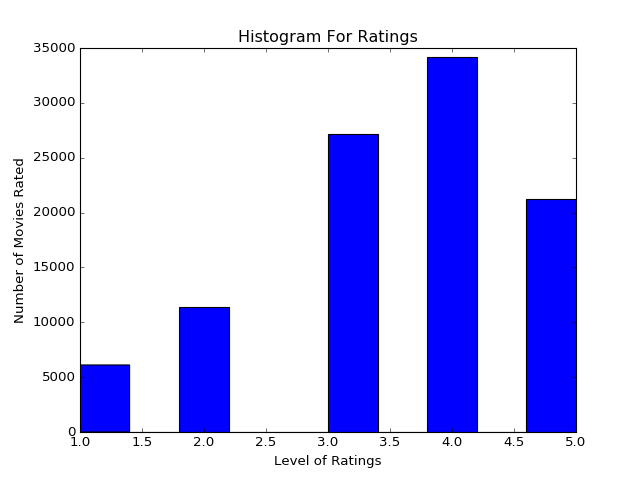

In [6]:
# plotting histogram from ratings
%matplotlib notebook
plt.hist(data['rating'])
plt.title("Histogram For Ratings")
plt.xlabel("Level of Ratings")
plt.ylabel("Number of Movies Rated")
plt.show()

#### The data sparsity can be calculated as follow
##### """ Sparsity = (# of ratings / # of movies * # of Users) * 100% """

In [7]:
# Now, we can recalculate the sparsity as we did earlier.
num_ratings = float(len(data))
num_movies = float(len(np.unique(data["item_id"])))
num_users = float(len(np.unique(data["user_id"])))
sparsity = (num_ratings / (num_movies * num_users)) * 100.0
print "Sparsity of Dataset is", sparsity, "Percent"

Sparsity of Dataset is 6.30466936422 Percent


In [8]:
# Get the column containing the users
users = data.user_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [9]:
# We want our users to have at least 50 ratings to be considred
RATINGS_CUTOFF = 50
remove_users = []
for user, num_ratings in ratings_count.iteritems():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
data = data.loc[~data.user_id.isin(remove_users)]

In [10]:
# Now, we can recalculate the sparsity as we did earlier.
num_ratings = float(len(data))
num_movies = float(len(np.unique(data["item_id"])))
num_users = float(len(np.unique(data["user_id"])))
sparsity = (num_ratings / (num_movies * num_users)) * 100.0
print "UPDATED Sparsity of Dataset is", sparsity, "Percent"


UPDATED Sparsity of Dataset is 9.26584192843 Percent


####   Integrating a Popularity Recommender ####

In [12]:
# convert our data to a graphlab SFrame object
sf = gl.SFrame(data)

#### Train/Test/Validation Split

In [13]:
# splitting into train and test set
sf_train, sf_test = sf.random_split(.70)

In [14]:
# splitting further the 70% train set into 75% train set and 25% validate set
sf_train, sf_validate = sf_train.random_split(.75)

#### Training data on trainset and examine RMSE on Test set
(using graphlab popularity reccomender)

In [15]:
import graphlab as gl
popularity_recommender = gl.recommender.popularity_recommender.create(sf_train, target='rating')
popularity_recommender.evaluate_rmse(sf_test, 'rating')

Recsys training: model = popularity

Preparing data set.

Data has 46642 observations with 568 users and 1583 items.

Data prepared in: 0.241014s

46642 observations to process; with 1583 unique items.

{'rmse_by_item': Columns:
 	item_id	int
 	count	int
 	rmse	float
 
 Rows: 1480
 
 Data:
 +---------+-------+----------------+
 | item_id | count |      rmse      |
 +---------+-------+----------------+
 |   118   |   76  | 1.11399712174  |
 |   660   |   45  | 1.00982156014  |
 |   1236  |   1   | 0.522490459243 |
 |   1379  |   3   | 1.37436854187  |
 |   699   |   33  | 1.13021740734  |
 |   567   |   8   | 1.32064892133  |
 |   773   |   6   | 1.01379375505  |
 |   1029  |   4   | 1.57797338381  |
 |   1504  |   2   | 0.707106781187 |
 |   435   |   59  | 0.812435324826 |
 +---------+-------+----------------+
 [1480 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	user_id	int
 	count	int
 	rmse	float
 
 Rows: 568
 
 Data:
 +---------+-------+----------------+
 | user_id | count |      rmse      |
 +---------+-------+----------------+
 |   118   |   23  | 1.

### Integrating a Collaborative Filtering Recommender ######

Using graphlab factorization recommender model


In [16]:
# We will try regularization terms in the range [10**-5, 10**-1]
regularization_terms = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1]

In [17]:
# We want to keep track of our best results as we go
best_regularization_term = 0
best_RMSE = np.inf
for regularization_term in regularization_terms:
    # Train with this reg term
    factorization_recommender = gl.recommender.factorization_recommender.create(sf_train,
                                                                                target='rating',
                                                                                regularization=regularization_term)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46642 observations with 568 users and 1583 items.

Data prepared in: 0.151009s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-005   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46642 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 0.703515                                 |

| 5       | 0.0488281         | 0.724791                                 |

| 6       | 0.0244141         | 0.768522                                 |

| 7       | 0.012207          | 0.834946                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 0.703515                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.25466           | 1.12012               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 110.006ms    | 1.0676            | 1.03317               | 0.0976562   |

| 2       | 260.015ms    | 0.929959          | 0.963368              | 0.0580668   |

| 3       | 288.016ms    | 0.861258          | 0.926357              | 0.042841    |

| 4       | 609.034ms    | 0.815352          | 0.900336              | 0.0345267   |

| 5       | 661.037ms    | 0.763899          | 0.870085              | 0.029206    |

| 6       | 716.041ms    | 0.712978          | 0.838893              | 0.0254734   |

| 10      | 1.37s        | 0.573047          | 0.745371              | 0.017366    |

| 11      | 1.55s        | 0.555659          | 0.73265               | 0.016168    |

| 20      | 2.30s        | 0.488976          | 0.680701              | 0.0103259   |

| 30      | 2.98s        | 0.465149          | 0.660282              | 0.00761832  |

| 40      | 3.52s        | 0.453154          | 0.649497              | 0.00613981  |

| 50      | 4.14s        | 0.446084          | 0.642872              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.423308

Final training RMSE: 0.624906

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46642 observations with 568 users and 1583 items.

Data prepared in: 0.193011s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46642 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 15.785            | Not Viable                               |

| 1       | 3.94626           | Not Viable                               |

| 2       | 0.986565          | Not Viable                               |

| 3       | 0.246641          | 0.439335                                 |

| 4       | 0.123321          | 0.703161                                 |

| 5       | 0.0616603         | 0.716477                                 |

| 6       | 0.0308301         | 0.752732                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.246641          | 0.439335                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.25467           | 1.12012               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 64.003ms     | DIVERGED          | DIVERGED              | 0.246641    |

| RESET   | 97.005ms     | 1.25467           | 1.12012               |             |

| 1       | 208.012ms    | DIVERGED          | DIVERGED              | 0.123321    |

| RESET   | 219.012ms    | 1.25467           | 1.12012               |             |

| 1       | 349.02ms     | 0.997436          | 0.998715              | 0.0616603   |

| 2       | 384.022ms    | 0.902561          | 0.950028              | 0.0366634   |

| 3       | 528.03ms     | 0.873545          | 0.934584              | 0.0270498   |

| 4       | 653.037ms    | 0.858822          | 0.926315              | 0.0218002   |

| 5       | 838.048ms    | 0.845158          | 0.917348              | 0.0184407   |

| 6       | 894.051ms    | 0.828122          | 0.904816              | 0.0160839   |

| 8       | 1.05s        | 0.800986          | 0.883746              | 0.0129625   |

| 11      | 1.27s        | 0.779502          | 0.865598              | 0.0102085   |

| 18      | 1.78s        | 0.735473          | 0.824371              | 0.00705588  |

| 28      | 2.58s        | 0.681935          | 0.764021              | 0.00506567  |

| 38      | 3.11s        | 0.655942          | 0.72437               | 0.00402873  |

| 48      | 3.87s        | 0.646832          | 0.704105              | 0.00338123  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.633984

Final training RMSE: 0.692809

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46642 observations with 568 users and 1583 items.

Data prepared in: 0.220013s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46642 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.5785            | Not Viable                               |

| 1       | 0.394626          | Not Viable                               |

| 2       | 0.0986565         | 0.725896                                 |

| 3       | 0.0493282         | 0.750041                                 |

| 4       | 0.0246641         | 0.784735                                 |

| 5       | 0.0123321         | 0.833725                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0986565         | 0.725896                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.25466           | 1.12012               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 202.012ms    | DIVERGED          | DIVERGED              | 0.0986565   |

| RESET   | 222.013ms    | 1.25468           | 1.12013               |             |

| 1       | 438.025ms    | DIVERGED          | DIVERGED              | 0.0493282   |

| RESET   | 455.026ms    | 1.2547            | 1.12013               |             |

| 1       | 546.032ms    | 0.967008          | 0.983364              | 0.0246641   |

| 2       | 666.038ms    | 0.867267          | 0.931271              | 0.0114696   |

| 3       | 792.046ms    | 0.846007          | 0.919786              | 0.00747224  |

| 4       | 912.053ms    | 0.836515          | 0.914612              | 0.00554106  |

| 5       | 1.03s        | 0.830758          | 0.911459              | 0.0044031   |

| 6       | 1.16s        | 0.827231          | 0.909522              | 0.0036529   |

| 8       | 1.33s        | 0.822575          | 0.906959              | 0.00272451  |

| 11      | 1.52s        | 0.818726          | 0.904835              | 0.00197252  |

| 18      | 1.85s        | 0.814451          | 0.902469              | 0.00119982  |

| 28      | 2.70s        | 0.811837          | 0.90102               | 0.000769303 |

| 38      | 3.33s        | 0.810464          | 0.900258              | 0.000566156 |

| 48      | 3.93s        | 0.809592          | 0.899773              | 0.000447884 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.808063

Final training RMSE: 0.898923

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46642 observations with 568 users and 1583 items.

Data prepared in: 0.143008s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46642 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.15785           | Not Viable                               |

| 1       | 0.0394626         | Not Viable                               |

| 2       | 0.00986565        | 0.948253                                 |

| 3       | 0.00493282        | 1.02087                                  |

| 4       | 0.00246641        | 1.08286                                  |

| 5       | 0.00123321        | 1.1383                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00986565        | 0.948253                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.25466           | 1.12012               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 109.006ms    | DIVERGED          | DIVERGED              | 0.00986565  |

| RESET   | 123.007ms    | 1.25474           | 1.12015               |             |

| 1       | 163.009ms    | 1.06213           | 1.0306                | 0.00493282  |

| 2       | 232.013ms    | 0.937377          | 0.968182              | 0.00149445  |

| 3       | 409.023ms    | 0.918054          | 0.958151              | 0.00088062  |

| 4       | 455.026ms    | 0.908539          | 0.953173              | 0.000624226 |

| 5       | 506.029ms    | 0.90252           | 0.95001               | 0.000483465 |

| 6       | 697.04ms     | 0.898226          | 0.947748              | 0.000394505 |

| 11      | 999.057ms    | 0.886755          | 0.941677              | 0.000205469 |

| 24      | 1.67s        | 0.875917          | 0.935904              |             |

| 49      | 2.71s        | 0.868299          | 0.931826              |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.867863

Final training RMSE: 0.931591

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46642 observations with 568 users and 1583 items.

Data prepared in: 0.208012s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46642 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.015785          | Not Viable                               |

| 1       | 0.00394626        | 1.10693                                  |

| 2       | 0.00197313        | 1.16848                                  |

| 3       | 0.000986565       | 1.20692                                  |

| 4       | 0.000493282       | 1.22974                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00394626        | 1.10693                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.25467           | 1.12012               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 110.006ms    | DIVERGED          | DIVERGED              | 0.00394626  |

| RESET   | 123.007ms    | 1.2547            | 1.12013               |             |

| 1       | 178.01ms     | DIVERGED          | DIVERGED              | 0.00197313  |

| RESET   | 193.011ms    | 1.2547            | 1.12013               |             |

| 1       | 248.014ms    | 1.18381           | 1.08803               | 0.000986565 |

| 2       | 350.02ms     | 1.11168           | 1.05436               | 0.000176124 |

| 3       | 391.022ms    | 1.0992            | 1.04843               |             |

| 4       | 429.024ms    | 1.09226           | 1.04511               | 6.6639e-005 |

| 5       | 464.026ms    | 1.08749           | 1.04283               |             |

| 6       | 616.035ms    | 1.08387           | 1.04109               |             |

| 11      | 978.055ms    | 1.07309           | 1.0359                |             |

| 23      | 1.94s        | 1.06167           | 1.03037               |             |

| 48      | 3.28s        | 1.05148           | 1.02542               |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.0508

Final training RMSE: 1.02508

In [18]:
# Evaluate on our validation set (NOT test set yet)
evaluation = factorization_recommender.evaluate_rmse(sf_validate, 'rating')
    # See if we found the best score yet
if evaluation['rmse_overall'] < best_RMSE:
    best_RMSE = evaluation['rmse_overall']
    best_regularization_term = regularization_term

print "Best Regularization Term", best_regularization_term
print "Best Validation RMSE Achieved", best_RMSE

Best Regularization Term 0.1
Best Validation RMSE Achieved 1.03376984179


In [19]:
# Now that we know the best parameter, we can use it to evaluate on our TEST set
factorization_recommender = gl.recommender.factorization_recommender.create(sf_train,
                                                                            target='rating',
                                                                            regularization=best_regularization_term)
print "Test RMSE on best model", factorization_recommender.evaluate_rmse(sf_test, 'rating')['rmse_overall']


Recsys training: model = factorization_recommender

Preparing data set.

Data has 46642 observations with 568 users and 1583 items.

Data prepared in: 0.126007s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46642 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.015785          | Not Viable                               |

| 1       | 0.00394626        | 1.10724                                  |

| 2       | 0.00197313        | 1.16856                                  |

| 3       | 0.000986565       | 1.20681                                  |

| 4       | 0.000493282       | 1.22964                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00394626        | 1.10724                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.25467           | 1.12012               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 81.005ms     | DIVERGED          | DIVERGED              | 0.00394626  |

| RESET   | 94.005ms     | 1.25468           | 1.12012               |             |

| 1       | 200.012ms    | DIVERGED          | DIVERGED              | 0.00197313  |

| RESET   | 219.013ms    | 1.2547            | 1.12013               |             |

| 1       | 254.015ms    | 1.1838            | 1.08802               | 0.000986565 |

| 2       | 299.017ms    | 1.11168           | 1.05436               | 0.000176124 |

| 3       | 337.019ms    | 1.09921           | 1.04843               |             |

| 4       | 377.022ms    | 1.09227           | 1.04512               | 6.6639e-005 |

| 5       | 418.024ms    | 1.0875            | 1.04283               |             |

| 6       | 478.027ms    | 1.08388           | 1.04109               |             |

| 11      | 796.046ms    | 1.0731            | 1.03591               |             |

| 23      | 1.66s        | 1.06168           | 1.03038               |             |

| 48      | 3.68s        | 1.0515            | 1.02542               |             |

+---------+--------------+-------------------+-----------------------+-------------+

Test RMSE on best model

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.05081

Final training RMSE: 1.02509

 1.0409264676


##### Integrating an Item-Item Similarity Recommender #####

In [20]:
# graphlab's Item-Item Similarity Recommender
item_similarity_recommender = gl.recommender.item_similarity_recommender.create(sf_train, target='rating')
test_rmse = item_similarity_recommender.evaluate_rmse(sf_test, 'rating')['rmse_overall']
print "Test RMSE on model", test_rmse

Recsys training: model = item_similarity

Preparing data set.

Data has 46642 observations with 568 users and 1583 items.

Data prepared in: 0.102006s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 19.001ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 214.012ms                           | 0.25             | 4               |

| 487.028ms                           | 100              | 1583            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.946054s

Test RMSE on model 3.67383571044


#### Getting Top k Recommendations ###############

In [21]:
# calculate the top k recommendations for each user
k=5
popularity_top_k = popularity_recommender.recommend(k=k)
factorization_top_k = factorization_recommender.recommend(k=k)
item_similarity_top_k = item_similarity_recommender.recommend(k=k)
print factorization_top_k

+---------+---------+---------------+------+
| user_id | item_id |     score     | rank |
+---------+---------+---------------+------+
|   244   |    50   | 4.04519540698 |  1   |
|   244   |   174   | 3.96801305444 |  2   |
|   244   |   127   | 3.96160466106 |  3   |
|   244   |    98   | 3.95758024485 |  4   |
|   244   |    64   | 3.93204925091 |  5   |
|   298   |    50   | 4.14142725126 |  1   |
|   298   |   174   | 4.06424489872 |  2   |
|   298   |    64   | 4.02828109519 |  3   |
|   298   |   172   |  4.0024915661 |  4   |
|   298   |   100   | 3.99847102419 |  5   |
+---------+---------+---------------+------+
[2840 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


###### Evaluation: Confusion Matrix, Precision and Recall ######

In [22]:
# calculate the precision/recall matrices between the three different models
models = [popularity_recommender, factorization_recommender, item_similarity_recommender]
model_names = ['popularity_recommender', 'factorization_recommender', 'item_similarity_recommender']
precision_recall = gl.recommender.util.compare_models(sf_test,
                                                      models,
                                                      metric='precision_recall',
                                                      model_names=model_names)

PROGRESS: Evaluate model popularity_recommender

Precision and recall summary statistics by cutoff
+--------+-------------------+-------------------+
| cutoff |   mean_precision  |    mean_recall    |
+--------+-------------------+-------------------+
|   1    |  0.00176056338028 | 2.70855904659e-05 |
|   2    |  0.00176056338028 | 5.64283134706e-05 |
|   3    |  0.00117370892019 | 5.64283134706e-05 |
|   4    | 0.000880281690141 | 5.64283134706e-05 |
|   5    |  0.00105633802817 | 8.27053788479e-05 |
|   6    |  0.00146713615023 | 0.000105335623216 |
|   7    |  0.00176056338028 | 0.000140993292173 |
|   8    |  0.00242077464789 | 0.000292208163967 |
|   9    |  0.00254303599374 | 0.000331067842109 |
|   10   |  0.00228873239437 | 0.000331067842109 |
+--------+-------------------+-------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model factorization_recommender

Precision and recall summary statistics by cutoff
+--------+----------------+------------------+
| cutoff | mean